In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import py_analyze_tools.tools as pat
import numpy as np
from pprint import pprint

In [2]:
traj = pat.Trajectory("../generate/simple_trajectory_2.h5")
traj.counts = traj.counts[:70*500]
traj.add_fusion(0, 1, 2)  # A + B -> C
traj.add_fusion(0, 2, 3)  # A + C -> D
traj.add_fusion(0, 3, 2)  # A + D -> C
traj.add_fusion(1, 2, 3)  # B + C -> D
traj.add_fission(2, 0, 1) # C -> A + B
traj.add_fission(0, 1, 2) # A -> B + C
traj.add_conversion(0, 1) # A -> B
traj.add_conversion(0, 3) # A -> D
traj.add_conversion(3, 0) # D -> A
traj.add_conversion(0, 2) # A -> C
traj.add_conversion(1, 2) # B -> C
traj.add_conversion(2, 3) # C -> D
traj.update()

traj2 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj2.counts = traj2.counts[:70*500]
traj2.add_fusion(0, 1, 2)  # A + B -> C ! (0)
traj2.add_fusion(0, 2, 3)  # A + C -> D
traj2.add_fusion(0, 3, 2)  # A + D -> C
traj2.add_fusion(1, 2, 3)  # B + C -> D
traj2.add_fission(2, 0, 1) # C -> A + B ! (4)
traj2.add_fission(0, 1, 2) # A -> B + C
traj2.add_conversion(0, 1) # A -> B
traj2.add_conversion(0, 3) # A -> D ! (7)
traj2.add_conversion(3, 0) # D -> A ! (8)
traj2.add_conversion(0, 2) # A -> C
traj2.add_conversion(1, 2) # B -> C
traj2.add_conversion(2, 3) # C -> D
traj2.update()

max counts = 6000.0, min nonzero counts = 1.0
max counts = 9000.0, min nonzero counts = 1.0


In [ ]:
cv = pat.CV(traj, traj2)
alpha, cv_result = cv.find_alpha(njobs=16, return_cv_result=True, n_grid_points=64, 
                                 train_indices=range(0, traj.n_time_steps//3), 
                                 test_indices=range(0, traj.n_time_steps//2))
print("found alpha=%s" % alpha)

In [ ]:
plt.plot(cv_result.alphas, cv_result.costs_test)

best suited alpha found at idx=48, alpha=0.009795918367346938, costs_test=0.01020342703780189
found alpha=0.00979591836735


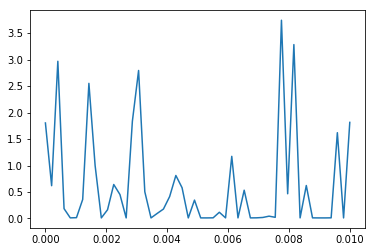

In [6]:
cv = pat.CV(traj, traj2)
alpha_2, cv_result_2 = cv.find_alpha(njobs=16, return_cv_result=True, n_grid_points=64, 
                                 train_indices=range(0, traj.n_time_steps//3), 
                                 test_indices=range(0, traj.n_time_steps//2), alphas=np.linspace(0, .01, num=50))
print("found alpha=%s" % alpha_2)
plt.plot(cv_result_2.alphas, cv_result_2.costs_test)

In [10]:
xi = traj.estimate(0.00979591836735)
print("found xi: {}".format(xi))

found xi: [  1.89278650e-06   0.00000000e+00   0.00000000e+00   6.05263072e-09
   9.10980266e-03   1.39416516e-04   4.65632881e-05   8.67965684e-03
   8.21920497e-03   1.18044342e-05   0.00000000e+00   2.00954450e-04]


In [11]:
xi[[0, 4, 7, 8]]

array([  1.89278650e-06,   9.10980266e-03,   8.67965684e-03,
         8.21920497e-03])

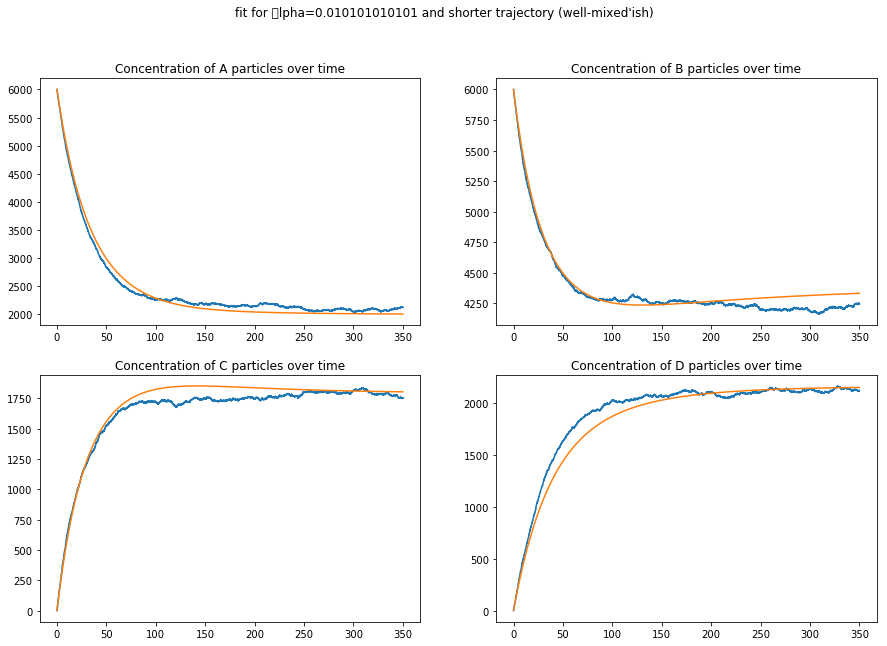

In [12]:
def fun(data, _):
    theta = np.array([f(data) for f in traj.thetas])
    return np.matmul(xi, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("fit for \alpha=%s and shorter trajectory (well-mixed'ish)" % alpha)
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()